Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 03: Analysis of behavioural data

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 7, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this exercise sheet we will start to work on a real dataset from an ongoing experiment. In this experiment the participants were asked to freely explore an unknown virtual city, called Seahaven, with an interactive map. After a sufficiently long exploration the participants were tested on three different tasks: 

- the **absolute orientation** of a single house towards the north cardinal direction
- the **relative orientation** between two houses 
- **pointing** from the location of one house to the other

Each task type was performed in two time conditions:

- **3 seconds** for spontaneous decisions
- **infinite** response time for cognitive reasoning

These measurements were repeated up to three times on different days.

We will provide you with more detailed information about this experiment in the tutorial. If you are interested in more than this feel free to have a look at the paper https://www.biorxiv.org/content/10.1101/539080v1.

A small side remark to the dataset: The RTs for the absolute task are exactly the same for both time conditions. This is an error that cannot be corrected on a short notice. Please keep that in mind, when you evaluate your plots.

## Assignment 0: Peer review for sheet 02 [3 pts]

Open an issue in the repository of the groups you have to check. The title of the issue should be your group name (e.g. "Group1). Comment on what was good and what was bad, the aesthetics and ease of reading the plots, what you would have done differently and how many points you would give them for their solutions.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 11, 9 | 5, 1  | 8, 2  | 2, 7 | 10, 6 | 7, 11 | 6, 5  | 4, 3  | 3, 8  | 1, 4   | 9, 10  |

## Assignment 1: Preprocessing [3 pts]

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats

warnings.simplefilter('ignore')


### a) Preprocessing the data [1 pt]

First of all you should preprocess the data. This is an important step to avoid running into any problems when you start to analyse the data. Since we provide the Seahaven dataset as an excel file make sure to run ```pip install xlrd``` in your activated acc environment beforehand. This allows you to directly read from excel files.

- Import the data of all three tasks (Absolute, Relative, Pointing) into one dataframe. Since we don't need the whole data, load only the columns "ReactionTime", "AngularDiffBin", "Subject", "Task", "Time", "Answer" and "Measurement".
- Clean the dataframe of all NaNs, i.e. remove all rows where at least one element is missing. How many rows have been removed?
- Change the values of the column "Answer". Replace each value "wrong" with 0 and each value "correct" with 1.

In [2]:
PATH = os.path.join(os.getcwd(), './Seahaven_dataset.xlsx')

sheets = pd.ExcelFile(PATH).sheet_names

# Reading each sheet with the required columns into a dataframe and storing the dataframes as a list
xl_sheets = [pd.read_excel(PATH, sheet_name=sheet, usecols=\
                           ["ReactionTime", "AngularDiffBin", "Subject", "Task", "Time", "Answer", "Measurement"],\
                          ) for sheet in sheets]
    
# Concatenating the sheets into one dataframe
xl_df = pd.concat(xl_sheets)

In [3]:
# Dropping all NA values and empty rows
xl_df.dropna(inplace=True)

# Converting the 'Answer' column
xl_df['Answer'] = (xl_df['Answer'] == 'correct').astype(int)

xl_df.head()

,ReactionTime,AngularDiffBin,Subject,Task,Time,Answer,Measurement
0,1.664824,150.0,1216.0,Absolute,3sec,0,1.0
1,0.865788,30.0,1216.0,Absolute,3sec,1,1.0
2,1.284187,60.0,1216.0,Absolute,3sec,0,1.0
3,2.081390,180.0,1216.0,Absolute,3sec,0,1.0
4,1.424746,120.0,1216.0,Absolute,3sec,1,1.0


### b) Checking the distribution of the data [2 pts]

Most of the analysis techniques require normally distributed data. To get an idea on how the data looks like use the **preprocessed data** from 1.a) and plot for each task a violinplot that displays the data distribution of the RTs (note that you also have to distinguish between the two time conditions - 3sec and Infinite).

- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) calculate the mean RT per subject.
- Make a violinplot for each combination of task and time condition (you should end up with 6 violinplots). Make sure that the data distributions are displayed clearly and that the y-axes are uniformly scaled to make your plots comparable. You may split up the single plots for a better overview.
- Hint: Play with the keyword inner.
- Using your plots, what can you say about the distribution of the data? It is normally distributed? How is it skewed?

In [4]:
# calculate the mean RT per subject for all combinations of task and time condition
avg_RT = xl_df.groupby(['Subject', 'Task', 'Time'])[['ReactionTime']].mean()

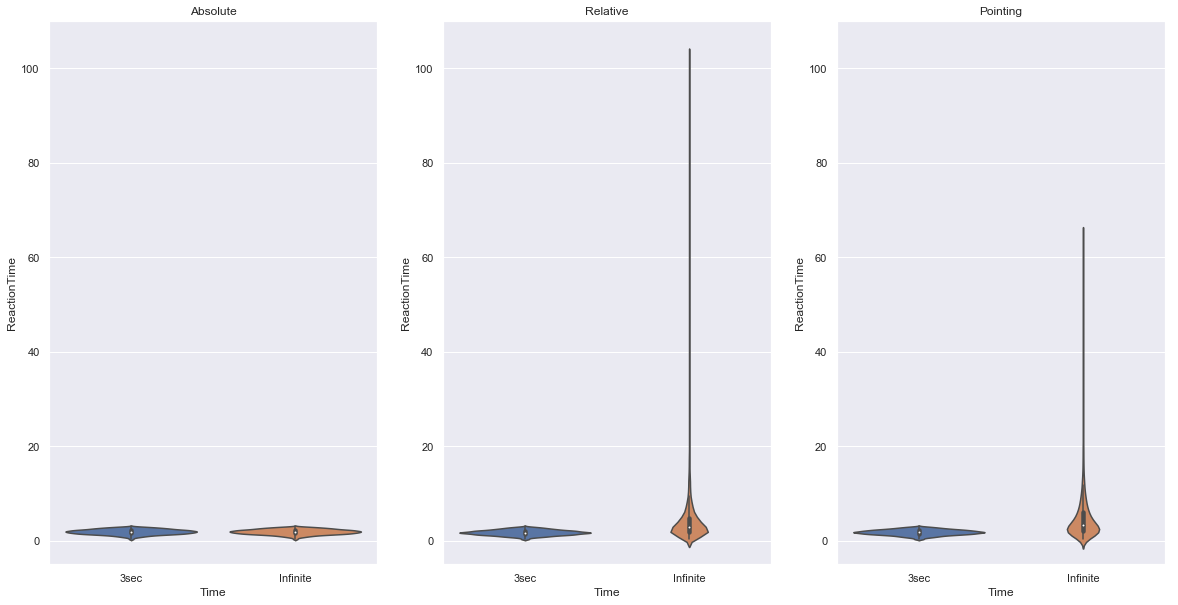

In [5]:
plt.figure(figsize = (20,10))

for i, task in enumerate(xl_df['Task'].unique()):
    df = xl_df.loc[xl_df['Task'] == task]
        
    # Violinplots for each task, categories: 3sec and Infinite
    plt.subplot(1,3,i+1).title.set_text(task)
    plt.ylim(-5,110)
    
    sns.violinplot(data=df, x='Time', y='ReactionTime')

**What can you say about the data?**

It seems normally distributed in all 3sec cases and the Infinite case of the Absolute tasks, but for all others there is an extreme skew that is most likely due to outliers in the data

------------------------------------------------------------

You may have noticed that there are (extreme) outliers, that have to be removed from the **preprocessed data**.

- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) look at the RTs and keep only the ones that are within +2 and -2 standard deviation:

$ |(RT_{group1} - mean(RT_{group1}))| \leq (2*std(RT_{group1})) $

$group1$ = e.g. data of absolute task for time condition 3sec

- Make again a violinplot for each combination of task and time condition (you should end up with 6 violinplots). Make sure that the data distributions are displayed clearly and that the y-axes are uniformly scaled to make your plots comparable. You may split up the single plots for a better overview.
- How does the distribution of the data look now? Is it still skewed?

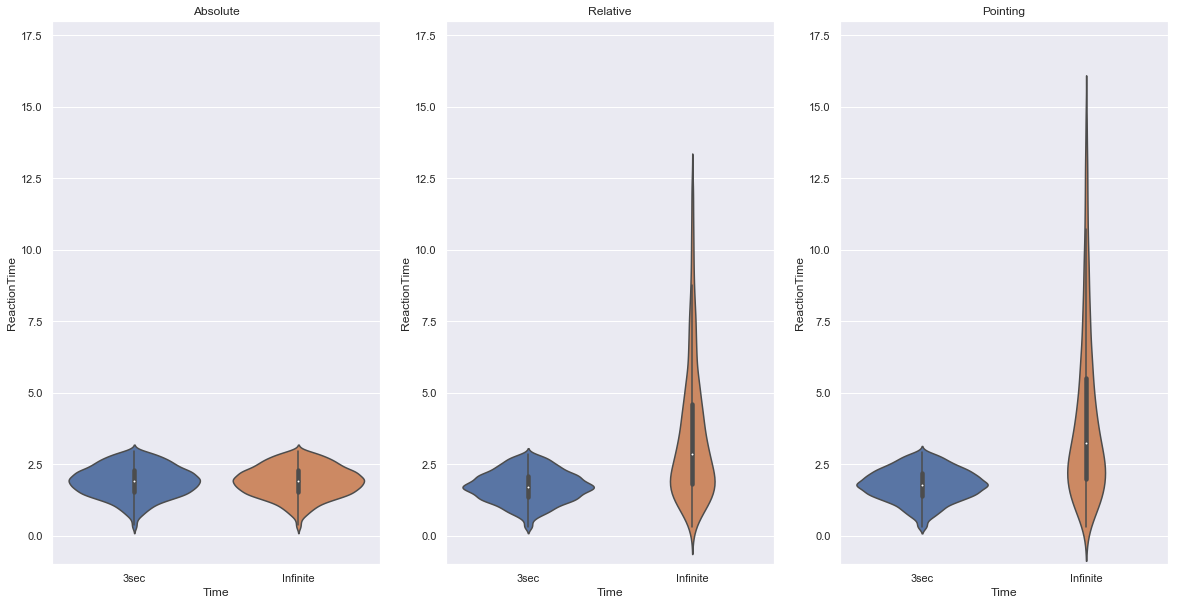

In [6]:
plt.figure(figsize = (20,10))

dropped_xl_df = []

for i, task in enumerate(xl_df['Task'].unique()):
    df = xl_df.loc[xl_df['Task'] == task]
    
    # mean and STD for 'Time' = 3sec 
    mean_3sec = df[df['Time'] == '3sec']['ReactionTime'].mean()
    std_3sec = df[df['Time'] == '3sec']['ReactionTime'].std()
    
    # mean and STD for 'Time' = Infinite
    mean_inf = df[df['Time'] == 'Infinite']['ReactionTime'].mean()
    std_inf = df[df['Time'] == 'Infinite']['ReactionTime'].std()
    
    # For each 'Time' category, all the rows which DO NOT meet the given condition are dropped
    df.drop(df[df['Time']=='3sec'][df['ReactionTime']-mean_3sec > 2*std_3sec]\
            .index, inplace=True)
    df.drop(df[df['Time']=='Infinite'][df['ReactionTime']-mean_inf > 2*std_inf]\
            .index, inplace=True)
    
    dropped_xl_df.append(df)
    
    # Violinplots for each task, categories: 3sec and Infinite
    plt.subplot(1,3,i+1).title.set_text(task)
    plt.ylim(-1,18)
    
    sns.violinplot(data=df, x='Time', y='ReactionTime')
    
new_xl_df = pd.concat(dropped_xl_df)

As we can see, the skew of the Infinite Time conditions for the relative and pointing tasks are less skewed, although there is still quite some skew left. They can not be considered normally distributed.

**Please make sure that you use the preprocessed data without outliers for the following assignments!**

## Assignment 2: Checking for possible hypotheses [5 pts]

### a) Hypothesis 1 [2 pt]

**Hypothesis 1:** "Given that subjects are limited by time, if they are faster in RT they are also less accurate."

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the mean RT and Accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a scatterplot of the mean RT (x-axis) and the accuracy (y-axis) for the time condition "3sec". 
- Make a second scatterplot and add a simple linear regression line to it. Calculate the slope of the regression line (you are allowed to use scipy). 
- Considering your results, what can you say about the hypothesis?

The slope of the regression line is 0.07446114707445553
The p-value is 0.031750715935225444


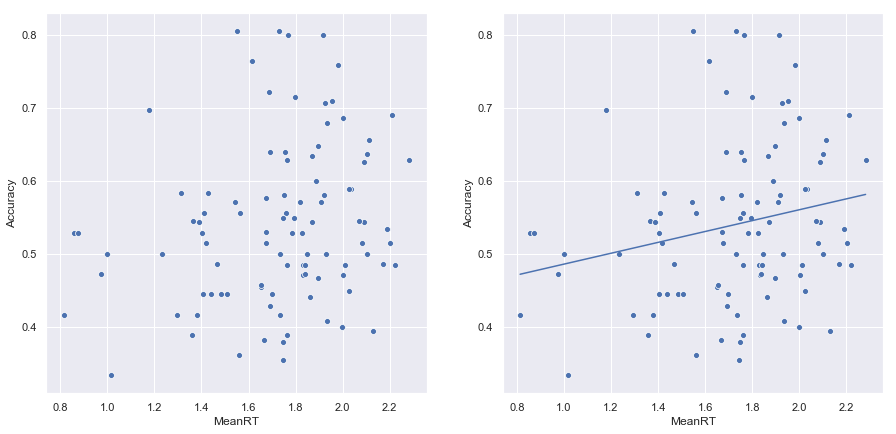

In [15]:
from scipy.stats import linregress

# Group the data by subject and time condition for only 'Relative' task and measure mean RT and Accuracy per subject
avg_RT_Accu = new_xl_df[new_xl_df['Task'] == 'Relative'].groupby(['Subject', 'Time'])[['ReactionTime', 'Answer']]\
              .mean().reset_index()

# Renaming 'Answer' to 'Accuracy' and 'ReactionTime' to 'MeanRT'
avg_RT_Accu.rename(columns={'ReactionTime' :'MeanRT', 'Answer':'Accuracy'}, inplace=True)

plt.figure(figsize = (15,7))
plt.subplot(121)
sns.scatterplot(data=avg_RT_Accu[avg_RT_Accu['Time']=='3sec'], x='MeanRT', y='Accuracy')

# Performing Linear Regression
m, b, R, p, stderr = linregress(avg_RT_Accu[avg_RT_Accu['Time']=='3sec']['MeanRT'],\
                                avg_RT_Accu[avg_RT_Accu['Time']=='3sec']['Accuracy'])
plt.subplot(122)
sns.scatterplot(data=avg_RT_Accu[avg_RT_Accu['Time']=='3sec'], x='MeanRT', y='Accuracy')
sns.lineplot(x = avg_RT_Accu[avg_RT_Accu['Time']=='3sec']['MeanRT'],\
             y = m*avg_RT_Accu[avg_RT_Accu['Time']=='3sec']['MeanRT']+b)
plt.ylabel("Accuracy")

print(f"The slope of the regression line is {m}")
print(f"The p-value is {p}")

**Considering your results, what can you say about the hypothesis?**

The slope of the regression line is positive (~0.074). If we consider the p-value (~0.031) and a significance niveau alpha of 0.05 for the two-sided Wald Test with the null hypothesis that the slope is zero we reject the null-hypothesis because the p-value is lower than alpha. For a smaller significance niveau (e.g. alpha = 0.01) we would not reject the null hypothesis. The choice of alpha is debatable.

### b) Hypothesis 2 [1 pt]

**Hypothesis 2:** "Given that subjects have infinite time, they perform better."

- Use the data of all three tasks.
- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the tasks (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance.
- Hint: Play with the keyword dodge.
- Considering your plots, what can you say about the hypothesis?

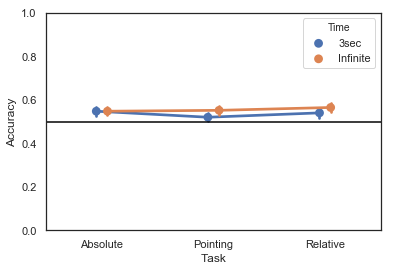

In [16]:
# Group the data by subject, task and time condition and measure mean Accuracy per subject
avg_Accu = new_xl_df.groupby(['Subject', 'Task', 'Time'])[['Answer']].mean().reset_index()

# Renaming 'Answer' to 'Accuracy' and 'ReactionTime' to 'MeanRT'
avg_Accu.rename(columns={'Answer':'Accuracy'}, inplace=True)


# Plot the pointplot 
sns.set_style('white')
sns.pointplot(data=avg_Accu, x='Task', y='Accuracy', hue='Time', dodge=0.1)
plt.ylim(0.0,1.0)
plt.axhline(0.5, alpha=1, color='black')
plt.show()

**Considering your plots, what can you say about the hypothesis?**

The plot tells us that for pointing and relative tasks, the subjects perform better if they have infinite time, because both mean and 95% confidence interval are above those of the 3sec condition. For the absolute condition this is not as clear, because as stated in the "small side remark to the dataset" above, the RTs for the absolute task for both the time conditions are the same!

### d) Hypothesis 3 [1 pt]

**Hypothesis 3:** "With each subsequent session subjects get better in performance."

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the mean RT and Accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the measurement (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance.
- Hint: Play with the keyword dodge.
- Make also a pointplot of the measurement (x-axis) and RT (y-axis) for both time conditions (3sec / Infinite).  Make sure that the data is displayed clearly. You may split up the single plots for a better overview.
- Considering your plots, what can you say about the hypothesis?

In [17]:
# We use the avg_RT_Accu dataframe from part a

avg_meas = new_xl_df.groupby(['Subject', 'Time'])['Measurement'].mean().reset_index(level=0, drop=True)

avg_RT_Accu['Measurement'] = avg_meas

# Plot the pointplot 
sns.set_style('white')
sns.pointplot(data=avg_RT_Accu, x='Measurement', y='Accuracy', hue='Time', dodge=0.1)
plt.ylim(0.0,1.0)
plt.axhline(0.5, alpha=1, color='black')
plt.show()

ValueError: cannot reindex from a duplicate axis

### c) Hypothesis 4 [1 pts]

**Hypothesis 4:** "When the angular difference between houses increases subjects are more accurate in the relative task."

- Use the data of the relative task.
- For each angular difference (see "AngularDiffBin") calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the angular differences (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance. Make sure that the angular differences are displayed in ascending order.
- Hint: Play with the keyword dodge.

- Considering your plots, what can you say about the hypothesis?

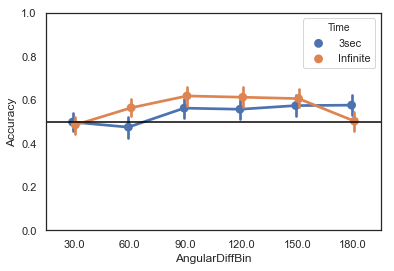

In [18]:
# Group the data by subject and time condition for only 'Relative' task and measure mean RT and Accuracy per subject
avg_AngDiff = new_xl_df[new_xl_df['Task'] == 'Relative'].groupby(['Subject', 'Time', 'AngularDiffBin'])\
              [['Answer']].mean().reset_index()

# Renaming 'Answer' to 'Accuracy' and 'ReactionTime' to 'MeanRT'
avg_AngDiff.rename(columns={'Answer':'Accuracy'}, inplace=True)


# Plot the pointplot
plt.ylim(0.0,1.0)
sns.pointplot(data=avg_AngDiff, x='AngularDiffBin', y='Accuracy', hue='Time', dodge=True)
plt.axhline(0.5, alpha=1, color='black')
plt.show()

**Considering your plots, what can you say about the hypothesis?**

When checking the hypothesis one should differentiate between the two time conditions, because for the 'infinite time' condition mean accuracy decreases for higher angular differene (has its peak at 90°) while it does indeed increase for the 3sec condition. If we calculate for both conditions at the same time though, it is clear that it decreases (see below). Just from the plots it seems like the hypothesis cannot be verified.

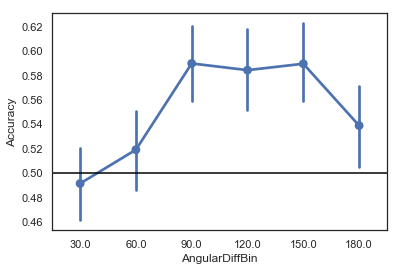

In [19]:
sns.pointplot(data=avg_AngDiff, x='AngularDiffBin', y='Accuracy', dodge=True)
plt.axhline(0.5, alpha=1, color='black')
plt.show()

## Assignment 3: T-test [2 pts]

We will perform a two-sample t-test, i.e. we compare the mean of two groups under the assumption that both are independent and normally distributed with unknown but equal variances. In this case we will look at the data of the relative task and compare the accuracies of the two time conditions (3sec / Infinte). We will ignore that there are different measurement days!

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Check if the data is normally distributed using scipy.stats.normaltest.


- Compute the t-statistics: $ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $

$\bar{x}_1$: mean accuracy of all subjects for time condition "3sec" <br>
$\bar{x}_2$: mean accuracy of all subjects for time condition "Infinite" <br>
$n_1$: sample size for time condition "3sec" <br>
$n_2$: sample size for time condition "Infinite"


- with $ s^2 = \frac{\sum_{i=1}^n{(x_i - \bar{x})^2}}{n-1} $

$x_i$: accuracy of subject i <br>
$\bar{x}$: mean accuracy of all subjects <br>
$n$: sample size


- Calculate the degrees of freedom: $ df = n_1 + n_2 -2 $
- What does the p-value of a t-test tell you in general? Also explain what your calculated p-value tells you specifically (given $\alpha = 0.05$)?

In [153]:
# Group the data by subject and time condition for only 'Relative' task and measure mean RT and Accuracy per subject as before
avg_Acc = new_xl_df[new_xl_df['Task'] == 'Relative'].groupby(['Subject', 'Time'])\
              [['Answer']].mean().reset_index()

# Renaming 'Answer' to 'Accuracy' and 'ReactionTime' to 'MeanRT'
avg_Acc.rename(columns={'Answer':'Accuracy'}, inplace=True)

# seperate the data into two dataframes for the two different time conditions for better readability
avg_Acc_3sec = avg_Acc[avg_Acc['Time'] == '3sec']
avg_Acc_inf = avg_Acc[avg_Acc['Time'] == 'Infinite']

# check whether the data from the two conditions is normally distributed
k1, p_3sec = stats.normaltest(avg_Acc_3sec[['Accuracy']])
k2, p_inf = stats.normaltest(avg_Acc_inf[['Accuracy']])
# choose an alpha level
alpha = 0.05
# check whether the null hypothesis can be rejected
# the null hypothesis is that the data comes from a normal distribution
if p_3sec > alpha:
    print("The data of the 3sec condition is normally distributed")
else:
    print("The data of the 3sec condition is not normally distributed")
    
if p_inf > alpha:
    print("The data of the infinite condition is normally distributed")
else:
    print("The data of the infinite condition is not normally distributed")
    
# calculate the t value with the given formula
# first define all variables as described above
x1 = avg_Acc_3sec[['Accuracy']].mean().reset_index()[0]
x2 = avg_Acc_inf[['Accuracy']].mean().reset_index()[0]
n1 = avg_Acc_3sec.shape[0]
n2 = avg_Acc_inf.shape[0]

# calculate the s^2 for the two conditions
sum1 = 0
for index, row in avg_Acc_3sec.iterrows():
    sum1 += (row['Accuracy'] - x1)**2
s1 = sum1/(n1-1)
    
sum2 = 0
for index, row in avg_Acc_inf.iterrows():
    sum2 += (row['Accuracy'] - x2)**2
s2 = sum2/(n2-1)   

# calculate the degrees of freedom
df = n1 + n2 - 2

# now that all variables are calculated we can proceed with the formula for the t value
t = (x1-x2)/(np.sqrt((s1/n1)+(s2/n2)))  
    
# gives you the p-value after comparing the t-statistic with the critical t value (computed internally) 
p = 1 - stats.t.cdf(abs(t),df=df)

print("t = " + str(t[0]))
print("p = " + str(2*p))

# test if your calculation is correct
t2, p2 = stats.ttest_ind(avg_Acc_3sec[['Accuracy']], avg_Acc_inf[['Accuracy']])
print("t2 = " + str(t2))
print("p2 = " + str(p2))

The data of the 3sec condition is normally distributed
The data of the infinite condition is not normally distributed
t = -1.5980870859517173
p = [0.11166799]
t2 = [-1.59808709]
p2 = [0.11166799]


**What does the p-value of a t-test tell you in general? Also explain what your calculated p-value tells you specifically (given  𝛼=0.05 )?**

The p-value of a t-test tells you the probability that the given t-values come from the same distribution (or in a different case that the t-value from a sample comes from a certain specified distribution). That means a very small p-value signifies that the t-values are very unlikely from the same distribution. A larger p-value, accordingly, means the t-values are similar enough to be likely from the same underlying distribution. 

In our case, the p-value is above alpha (=0.05) therefore we wouldn't reject the null hypothesis, which is that the data comes from the same distribution. In other words, with this result we cannot assume that there is a significant difference between the two time conditions in the accuracy.